In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import keras
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint

import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix   

2023-05-22 07:29:51.378768: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-22 07:29:51.378832: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Import the data

In [2]:
import pandas as pd
from sklearn.utils import shuffle

# Read the CSV file into a pandas DataFrame
data = pd.read_csv("rumus + data skripsi angka polos jarak dan visibilitas 2.csv")

In [3]:
def get_data_with_ratio(ratio):
    # Shuffle the data
    shuffled_data = shuffle(data, random_state=42)

    # Get unique classes from the "Peruntukan" column
    classes = shuffled_data['Peruntukan'].unique()

    # Initialize empty dataframes for train and test data
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    # Iterate over each class
    for cls in classes:
        cls_data = shuffled_data[shuffled_data['Peruntukan'] == cls]

        # Split the class data into train and test
        cls_train, cls_test = train_test_split(cls_data, test_size=ratio, random_state=42)

        # Append the train and test data to the respective dataframes
        train_data = train_data.append(cls_train)
        test_data = test_data.append(cls_test)
        
        training = train_data
        test = test_data

        training = training[["Peruntukan","Jarak pusat kota2","Visibilitas","Bangunan","Luas"]]
        test = test[["Peruntukan","Jarak pusat kota2","Visibilitas","Bangunan","Luas"]]


    
    return training, test


# Data visualisasi

# Change categorical to number 

In [4]:
def change_categorical_to_number(data):
    
    data = data
    
 
    ####
    ####

    condition = [  data.Visibilitas == "Strategis",
                 data.Visibilitas == "Sedang",
                  data.Visibilitas == "Kurang",
    ]

    value = [3,2,1]

    data.Visibilitas = np.select(condition,value)
    #####
    #####

    condition = [  data.Bangunan == "Bagus",
                 data.Bangunan == "Sedang",

    ]

    value = [2,1]

    data.Bangunan = np.select(condition,value,0)


    condition = [ 
                data.Peruntukan == "Pasar",
                 data.Peruntukan == "Kantor",
                 data.Peruntukan == "Ruko",
                 data.Peruntukan == "Taman",
                 data.Peruntukan == "Perumahan",
                 data.Peruntukan == "Sawah",

    ]

    value = [5,4,3,2,1,0]

    data.Peruntukan = np.select(condition,value,0)
    
    return data

# Dataframe to Dataset

In [5]:
def df_to_dataset(dataframe, shuffle=False, batch_size=4):
  dataframe = dataframe.copy()
  labels = dataframe.pop('Peruntukan')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

# Feature Normalizer

In [6]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [7]:
def encoded_features(train_ds):
    all_inputs = []
    encoded_features = []

    # Numerical features.
    for header in ["Jarak pusat kota2","Visibilitas","Bangunan","Luas"]:
      numeric_col = tf.keras.Input(shape=(1,), name=header)
      normalization_layer = get_normalization_layer(header, train_ds)
      encoded_numeric_col = normalization_layer(numeric_col)
      all_inputs.append(numeric_col)
      encoded_features.append(encoded_numeric_col)
    return encoded_features, all_inputs

In [8]:
checkpoint_callback = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True, mode='max')

# Model build

In [9]:
def model(encoded_features,all_inputs):
    
    all_features = tf.keras.layers.concatenate(encoded_features)
    x = tf.keras.layers.Dense(32, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(6)(x)

    model = tf.keras.Model(all_inputs, output)

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics="accuracy",
                 )
    
    return model

# History build

In [10]:
def history(model,callbacks,train_ds,val_ds):
    

    history = model.fit(train_ds, epochs=150, validation_data=val_ds, callbacks=callbacks)

    # Get the training and validation metrics from the history
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot accuracy
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    max_test_accuracy_index = history.history['val_accuracy'].index(max(history.history['val_accuracy']))

    # Get the corresponding training accuracy
    training_accuracy = history.history['accuracy'][max_test_accuracy_index]

    print('Best validation accuracy:', max(history.history['val_accuracy']))
    print('Training accuracy at the best test accuracy:', training_accuracy)
    
    return history


# Evaluation the Model

In [11]:
def run_model(ratio,callbacks):
    
    #split data
    training, test_2 = get_data_with_ratio(ratio)
    
    #change data to number
    training = change_categorical_to_number(training)
    test = change_categorical_to_number(test_2)
    
    #df to ds
    
    train_ds = df_to_dataset(training)
    val_ds = df_to_dataset(test)
    
    #encoded features
    
    encoded,inputs = encoded_features(train_ds)

    
    #set the model
    model_engine = model(encoded,inputs)
    
    #run and evaluate the model
    model_engine2 = history(model_engine,callbacks,train_ds,val_ds)
    
    #evaluate confusion matrix
    confussion_matrix(model_engine2,val_ds,test_2)

In [12]:
def confussion_matrix(best_model, val_ds,test_data):
    from sklearn.metrics import confusion_matrix   
    model =  best_model
    
    y_pred = model.model.predict(val_ds)

    # Ubah output prediksi menjadi label kelas
    label_kelas = [0, 1, 2, 3, 4, 5]
    y_pred_label = [label_kelas[np.argmax(prediksi)] for prediksi in y_pred]

    #test label
    test_labels = test_data.Peruntukan

    # Calculate the confusion matrix
    cm = confusion_matrix(test_labels, y_pred_label)
    
    max_test_accuracy_index = model.history['val_accuracy'].index(max(model.history['val_accuracy']))

    # Get the corresponding training accuracy
    training_accuracy = model.history['accuracy'][max_test_accuracy_index]

    print('Best validation accuracy:', max(model.history['val_accuracy']))
    print('Training accuracy at the best test accuracy:', training_accuracy)


    print('Confusion matrix:')
    print(cm)
    
    confusion_matrix = cm
    
    true_positives = np.diagonal(confusion_matrix)

    # Step 3: Calculate the accuracy percentage for each class
    class_data_totals = np.sum(confusion_matrix, axis=0)
    class_accuracies = true_positives / class_data_totals * 100

    # Step 4: Calculate the overall accuracy percentage
    total_instances = np.sum(confusion_matrix)
    overall_accuracy = np.sum(true_positives) / total_instances * 100

    
    for label, accuracy in zip(label_kelas, class_accuracies):
        print("Accuracy for", label, ":", accuracy)
    
    
    
    true_positives = np.diagonal(confusion_matrix)
    false_positives = np.sum(confusion_matrix, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix, axis=1) - true_positives

    # Step 3: Calculate precision, recall, and F1 score for each label
    accuracy = true_positives / np.sum(confusion_matrix, axis=1)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Step 4: Calculate the total accuracy
    total_accuracy = np.sum(true_positives) / np.sum(confusion_matrix) * 100
    total_precision = np.mean(precision)
    total_recall = np.mean(recall)
    total_f1 = np.mean(f1_score)

    # Print the results
    print("Total Precision:", total_precision)
    print("Total Recall:", total_recall)
    print("Total F1 Score:", total_f1)

    # Print the results
    print("Accuracy for each label:", class_accuracies)
    print("Precision for each label:", precision)
    print("Recall for each label:", recall)
    print("F1 Score for each label:", f1_score)
    print("Total Accuracy:", total_accuracy)

# Model Evaluation

In [13]:
callback_1 = ModelCheckpoint("final 50.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_1 = 0.5

callback_2= ModelCheckpoint("final 40.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_2 = 0.4

callback_3= ModelCheckpoint("final 30.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_3 = 0.3

callback_4= ModelCheckpoint("final 20.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_4 = 0.2

callback_5= ModelCheckpoint("final 10.h5", monitor='val_accuracy', save_best_only=True, mode='max')
ratio_5 = 0.1

/tmp/ipykernel_34538/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_34538/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_34538/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_34538/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_34538/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

Epoch 1/150
13/13 [==============================] - 1s 31ms/step - loss: 2.0253 - accuracy: 0.0408 - val_loss: 2.0215 - val_accuracy: 0.0000e+00
Epoch 2/150
13/13 [==============================] - 0s 8ms/step - loss: 1.9050 - accuracy: 0.0612 - val_loss: 1.9662 - val_accuracy: 0.0000e+00
Epoch 3/150
13/13 [==============================] - 0s 11ms/step - loss: 1.8019 - accuracy: 0.1837 - val_loss: 1.9183 - val_accuracy: 0.0185
Epoch 4/150
13/13 [==============================] - 0s 10ms/step - loss: 1.8525 - accuracy: 0.1020 - val_loss: 1.8717 - val_accuracy: 0.2037
Epoch 5/150
13/13 [==============================] - 0s 7ms/step - loss: 1.7136 - accuracy: 0.1633 - val_loss: 1.8310 - val_accuracy: 0.2037
Epoch 6/150
13/13 [==============================] - 0s 10ms/step - loss: 1.6889 - accuracy: 0.2449 - val_loss: 1.7922 - val_accuracy: 0.2222
Epoch 7/150
13/13 [==============================] - 0s 7ms/step - loss: 1.7362 - accuracy: 0.2041 - val_loss: 1.7529 - val_accuracy: 0.2222
E

13/13 [==============================] - 0s 6ms/step - loss: 0.9102 - accuracy: 0.7143 - val_loss: 0.8578 - val_accuracy: 0.7037
Epoch 59/150
13/13 [==============================] - 0s 7ms/step - loss: 0.8117 - accuracy: 0.7347 - val_loss: 0.8514 - val_accuracy: 0.7037
Epoch 60/150
13/13 [==============================] - 0s 7ms/step - loss: 0.8719 - accuracy: 0.6122 - val_loss: 0.8450 - val_accuracy: 0.7037
Epoch 61/150
13/13 [==============================] - 0s 7ms/step - loss: 0.8745 - accuracy: 0.7347 - val_loss: 0.8408 - val_accuracy: 0.7037
Epoch 62/150
13/13 [==============================] - 0s 7ms/step - loss: 0.8683 - accuracy: 0.6531 - val_loss: 0.8355 - val_accuracy: 0.7037
Epoch 63/150
13/13 [==============================] - 0s 7ms/step - loss: 0.8456 - accuracy: 0.6735 - val_loss: 0.8282 - val_accuracy: 0.7037
Epoch 64/150
13/13 [==============================] - 0s 7ms/step - loss: 0.8525 - accuracy: 0.6531 - val_loss: 0.8221 - val_accuracy: 0.7037
Epoch 65/150
13/13 

13/13 [==============================] - 0s 7ms/step - loss: 0.5541 - accuracy: 0.8571 - val_loss: 0.6429 - val_accuracy: 0.8333
Epoch 116/150
13/13 [==============================] - 0s 7ms/step - loss: 0.5551 - accuracy: 0.8163 - val_loss: 0.6449 - val_accuracy: 0.8333
Epoch 117/150
13/13 [==============================] - 0s 7ms/step - loss: 0.5537 - accuracy: 0.7959 - val_loss: 0.6435 - val_accuracy: 0.8333
Epoch 118/150
13/13 [==============================] - 0s 8ms/step - loss: 0.5565 - accuracy: 0.8980 - val_loss: 0.6429 - val_accuracy: 0.8333
Epoch 119/150
13/13 [==============================] - 0s 9ms/step - loss: 0.5028 - accuracy: 0.8571 - val_loss: 0.6445 - val_accuracy: 0.8333
Epoch 120/150
13/13 [==============================] - 0s 8ms/step - loss: 0.5473 - accuracy: 0.7143 - val_loss: 0.6431 - val_accuracy: 0.8333
Epoch 121/150
13/13 [==============================] - 0s 8ms/step - loss: 0.5545 - accuracy: 0.7959 - val_loss: 0.6406 - val_accuracy: 0.8333
Epoch 122/150

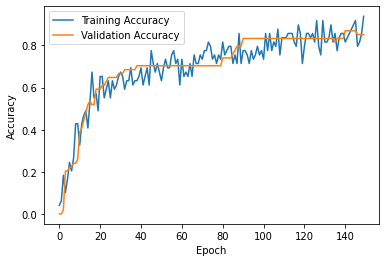

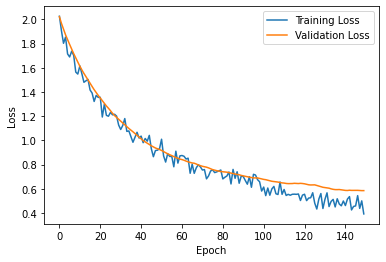

Best validation accuracy: 0.8703703880310059
Training accuracy at the best test accuracy: 0.8163265585899353
Best validation accuracy: 0.8703703880310059
Training accuracy at the best test accuracy: 0.8163265585899353
Confusion matrix:
[[12  0  0  0  0  0]
 [ 1  2  0  0  0  1]
 [ 1  0  2  0  0  0]
 [ 0  0  0 20  0  1]
 [ 0  0  0  0  6  0]
 [ 0  0  0  4  0  4]]
Accuracy for 0 : 85.71428571428571
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 83.33333333333334
Accuracy for 4 : 100.0
Accuracy for 5 : 66.66666666666666
Total Precision: 0.8928571428571429
Total Recall: 0.7698412698412698
Total F1 Score: 0.8083435083435083
Accuracy for each label: [ 85.71428571 100.         100.          83.33333333 100.
  66.66666667]
Precision for each label: [0.85714286 1.         1.         0.83333333 1.         0.66666667]
Recall for each label: [1.         0.5        0.66666667 0.95238095 1.         0.5       ]
F1 Score for each label: [0.92307692 0.66666667 0.8        0.88888889 1.    

In [14]:
run_model(ratio_1, callback_1)

/tmp/ipykernel_34538/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_34538/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_34538/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_34538/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_34538/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

Epoch 1/150
15/15 [==============================] - 1s 48ms/step - loss: 1.7946 - accuracy: 0.2333 - val_loss: 1.7438 - val_accuracy: 0.1628
Epoch 2/150
15/15 [==============================] - 0s 9ms/step - loss: 1.8568 - accuracy: 0.2833 - val_loss: 1.6871 - val_accuracy: 0.1628
Epoch 3/150
15/15 [==============================] - 0s 11ms/step - loss: 1.8207 - accuracy: 0.1833 - val_loss: 1.6344 - val_accuracy: 0.3256
Epoch 4/150
15/15 [==============================] - 0s 12ms/step - loss: 1.7249 - accuracy: 0.3667 - val_loss: 1.5839 - val_accuracy: 0.4186
Epoch 5/150
15/15 [==============================] - 0s 14ms/step - loss: 1.7442 - accuracy: 0.2833 - val_loss: 1.5362 - val_accuracy: 0.4651
Epoch 6/150
15/15 [==============================] - 0s 9ms/step - loss: 1.6409 - accuracy: 0.3667 - val_loss: 1.4942 - val_accuracy: 0.4651
Epoch 7/150
15/15 [==============================] - 0s 10ms/step - loss: 1.5123 - accuracy: 0.4333 - val_loss: 1.4536 - val_accuracy: 0.5116
Epoch 8/

15/15 [==============================] - 0s 9ms/step - loss: 0.7426 - accuracy: 0.7000 - val_loss: 0.5742 - val_accuracy: 0.8605
Epoch 59/150
15/15 [==============================] - 0s 9ms/step - loss: 0.6644 - accuracy: 0.7833 - val_loss: 0.5661 - val_accuracy: 0.8837
Epoch 60/150
15/15 [==============================] - 0s 6ms/step - loss: 0.7141 - accuracy: 0.7333 - val_loss: 0.5582 - val_accuracy: 0.8837
Epoch 61/150
15/15 [==============================] - 0s 9ms/step - loss: 0.7102 - accuracy: 0.7500 - val_loss: 0.5509 - val_accuracy: 0.9070
Epoch 62/150
15/15 [==============================] - 0s 6ms/step - loss: 0.6809 - accuracy: 0.7167 - val_loss: 0.5448 - val_accuracy: 0.9070
Epoch 63/150
15/15 [==============================] - 0s 6ms/step - loss: 0.6442 - accuracy: 0.7833 - val_loss: 0.5394 - val_accuracy: 0.9070
Epoch 64/150
15/15 [==============================] - 0s 9ms/step - loss: 0.6208 - accuracy: 0.7833 - val_loss: 0.5326 - val_accuracy: 0.9070
Epoch 65/150
15/15 

Epoch 116/150
15/15 [==============================] - 0s 7ms/step - loss: 0.4745 - accuracy: 0.8333 - val_loss: 0.3721 - val_accuracy: 0.8837
Epoch 117/150
15/15 [==============================] - 0s 7ms/step - loss: 0.4079 - accuracy: 0.8167 - val_loss: 0.3724 - val_accuracy: 0.8837
Epoch 118/150
15/15 [==============================] - 0s 6ms/step - loss: 0.5040 - accuracy: 0.8667 - val_loss: 0.3730 - val_accuracy: 0.8837
Epoch 119/150
15/15 [==============================] - 0s 6ms/step - loss: 0.4207 - accuracy: 0.8333 - val_loss: 0.3715 - val_accuracy: 0.8837
Epoch 120/150
15/15 [==============================] - 0s 6ms/step - loss: 0.4021 - accuracy: 0.9167 - val_loss: 0.3688 - val_accuracy: 0.9070
Epoch 121/150
15/15 [==============================] - 0s 6ms/step - loss: 0.3888 - accuracy: 0.8500 - val_loss: 0.3658 - val_accuracy: 0.9070
Epoch 122/150
15/15 [==============================] - 0s 6ms/step - loss: 0.4066 - accuracy: 0.8667 - val_loss: 0.3648 - val_accuracy: 0.9070

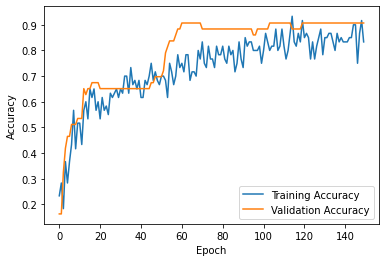

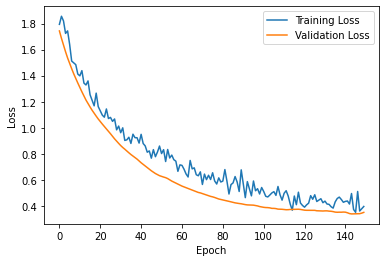

Best validation accuracy: 0.9069767594337463
Training accuracy at the best test accuracy: 0.75
Best validation accuracy: 0.9069767594337463
Training accuracy at the best test accuracy: 0.75
Confusion matrix:
[[10  0  0  0  0  0]
 [ 0  3  0  0  0  0]
 [ 0  0  2  0  0  0]
 [ 0  0  0 16  0  1]
 [ 0  0  0  0  5  0]
 [ 0  0  0  3  0  3]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 84.21052631578947
Accuracy for 4 : 100.0
Accuracy for 5 : 75.0
Total Precision: 0.9320175438596491
Total Recall: 0.9068627450980392
Total F1 Score: 0.9148148148148149
Accuracy for each label: [100.         100.         100.          84.21052632 100.
  75.        ]
Precision for each label: [1.         1.         1.         0.84210526 1.         0.75      ]
Recall for each label: [1.         1.         1.         0.94117647 1.         0.5       ]
F1 Score for each label: [1.         1.         1.         0.88888889 1.         0.6       ]
Total Accuracy: 90.69767441860465


In [15]:
run_model(ratio_2, callback_2)

/tmp/ipykernel_34538/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_34538/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_34538/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_34538/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_34538/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

Epoch 1/150
18/18 [==============================] - 1s 26ms/step - loss: 1.7856 - accuracy: 0.2609 - val_loss: 1.8431 - val_accuracy: 0.2941
Epoch 2/150
18/18 [==============================] - 0s 8ms/step - loss: 1.7308 - accuracy: 0.3478 - val_loss: 1.7725 - val_accuracy: 0.4118
Epoch 3/150
18/18 [==============================] - 0s 9ms/step - loss: 1.6968 - accuracy: 0.3623 - val_loss: 1.7036 - val_accuracy: 0.4706
Epoch 4/150
18/18 [==============================] - 0s 10ms/step - loss: 1.5950 - accuracy: 0.4058 - val_loss: 1.6434 - val_accuracy: 0.5000
Epoch 5/150
18/18 [==============================] - 0s 9ms/step - loss: 1.5137 - accuracy: 0.4493 - val_loss: 1.5872 - val_accuracy: 0.5588
Epoch 6/150
18/18 [==============================] - 0s 10ms/step - loss: 1.5227 - accuracy: 0.4348 - val_loss: 1.5393 - val_accuracy: 0.5882
Epoch 7/150
18/18 [==============================] - 0s 7ms/step - loss: 1.4578 - accuracy: 0.4493 - val_loss: 1.4990 - val_accuracy: 0.5882
Epoch 8/15

Epoch 59/150
18/18 [==============================] - 0s 5ms/step - loss: 0.6475 - accuracy: 0.7681 - val_loss: 0.5751 - val_accuracy: 0.7647
Epoch 60/150
18/18 [==============================] - 0s 9ms/step - loss: 0.6310 - accuracy: 0.8261 - val_loss: 0.5689 - val_accuracy: 0.7941
Epoch 61/150
18/18 [==============================] - 0s 8ms/step - loss: 0.6858 - accuracy: 0.7826 - val_loss: 0.5614 - val_accuracy: 0.8529
Epoch 62/150
18/18 [==============================] - 0s 5ms/step - loss: 0.6669 - accuracy: 0.7536 - val_loss: 0.5544 - val_accuracy: 0.8529
Epoch 63/150
18/18 [==============================] - 0s 5ms/step - loss: 0.6735 - accuracy: 0.8116 - val_loss: 0.5475 - val_accuracy: 0.8235
Epoch 64/150
18/18 [==============================] - 0s 6ms/step - loss: 0.6037 - accuracy: 0.7971 - val_loss: 0.5427 - val_accuracy: 0.8529
Epoch 65/150
18/18 [==============================] - 0s 6ms/step - loss: 0.6001 - accuracy: 0.8116 - val_loss: 0.5358 - val_accuracy: 0.8529
Epoch 

18/18 [==============================] - 0s 5ms/step - loss: 0.4344 - accuracy: 0.8261 - val_loss: 0.3557 - val_accuracy: 0.9118
Epoch 117/150
18/18 [==============================] - 0s 5ms/step - loss: 0.4350 - accuracy: 0.7971 - val_loss: 0.3533 - val_accuracy: 0.9118
Epoch 118/150
18/18 [==============================] - 0s 5ms/step - loss: 0.4171 - accuracy: 0.8116 - val_loss: 0.3502 - val_accuracy: 0.9118
Epoch 119/150
18/18 [==============================] - 0s 6ms/step - loss: 0.3943 - accuracy: 0.8696 - val_loss: 0.3462 - val_accuracy: 0.9118
Epoch 120/150
18/18 [==============================] - 0s 5ms/step - loss: 0.4412 - accuracy: 0.8551 - val_loss: 0.3423 - val_accuracy: 0.9118
Epoch 121/150
18/18 [==============================] - 0s 6ms/step - loss: 0.4416 - accuracy: 0.8261 - val_loss: 0.3410 - val_accuracy: 0.9118
Epoch 122/150
18/18 [==============================] - 0s 6ms/step - loss: 0.4661 - accuracy: 0.7826 - val_loss: 0.3393 - val_accuracy: 0.9118
Epoch 123/150

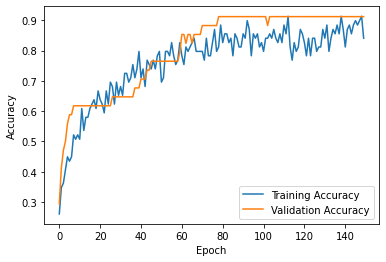

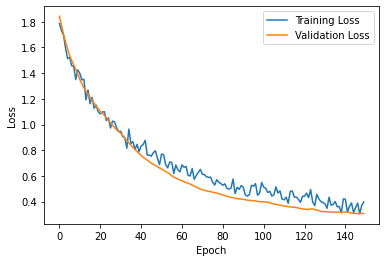

Best validation accuracy: 0.9117646813392639
Training accuracy at the best test accuracy: 0.8115941882133484
Best validation accuracy: 0.9117646813392639
Training accuracy at the best test accuracy: 0.8115941882133484
Confusion matrix:
[[ 7  0  0  0  0  0]
 [ 0  3  0  0  0  0]
 [ 0  0  2  0  0  0]
 [ 0  0  0 13  0  0]
 [ 0  0  0  0  4  0]
 [ 0  0  0  3  0  2]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 81.25
Accuracy for 4 : 100.0
Accuracy for 5 : 100.0
Total Precision: 0.96875
Total Recall: 0.9
Total F1 Score: 0.9113300492610836
Accuracy for each label: [100.   100.   100.    81.25 100.   100.  ]
Precision for each label: [1.     1.     1.     0.8125 1.     1.    ]
Recall for each label: [1.  1.  1.  1.  1.  0.4]
F1 Score for each label: [1.         1.         1.         0.89655172 1.         0.57142857]
Total Accuracy: 91.17647058823529


In [16]:
run_model(ratio_3, callback_3)

/tmp/ipykernel_34538/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_34538/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_34538/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_34538/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_34538/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

Epoch 1/150
20/20 [==============================] - 1s 18ms/step - loss: 1.9114 - accuracy: 0.2625 - val_loss: 1.8636 - val_accuracy: 0.1739
Epoch 2/150
20/20 [==============================] - 0s 5ms/step - loss: 1.9467 - accuracy: 0.2250 - val_loss: 1.7744 - val_accuracy: 0.1739
Epoch 3/150
20/20 [==============================] - 0s 7ms/step - loss: 1.8767 - accuracy: 0.2875 - val_loss: 1.6917 - val_accuracy: 0.2174
Epoch 4/150
20/20 [==============================] - 0s 5ms/step - loss: 1.7211 - accuracy: 0.3375 - val_loss: 1.6141 - val_accuracy: 0.2174
Epoch 5/150
20/20 [==============================] - 0s 7ms/step - loss: 1.6691 - accuracy: 0.3375 - val_loss: 1.5486 - val_accuracy: 0.3913
Epoch 6/150
20/20 [==============================] - 0s 5ms/step - loss: 1.6671 - accuracy: 0.3500 - val_loss: 1.4910 - val_accuracy: 0.3913
Epoch 7/150
20/20 [==============================] - 0s 7ms/step - loss: 1.6880 - accuracy: 0.3125 - val_loss: 1.4325 - val_accuracy: 0.4348
Epoch 8/150


Epoch 59/150
20/20 [==============================] - 0s 5ms/step - loss: 0.7165 - accuracy: 0.7375 - val_loss: 0.5195 - val_accuracy: 0.9130
Epoch 60/150
20/20 [==============================] - 0s 5ms/step - loss: 0.6754 - accuracy: 0.7500 - val_loss: 0.5144 - val_accuracy: 0.9130
Epoch 61/150
20/20 [==============================] - 0s 5ms/step - loss: 0.7141 - accuracy: 0.7375 - val_loss: 0.5086 - val_accuracy: 0.9130
Epoch 62/150
20/20 [==============================] - 0s 5ms/step - loss: 0.7105 - accuracy: 0.6375 - val_loss: 0.5039 - val_accuracy: 0.9130
Epoch 63/150
20/20 [==============================] - 0s 5ms/step - loss: 0.6363 - accuracy: 0.7125 - val_loss: 0.4951 - val_accuracy: 0.9130
Epoch 64/150
20/20 [==============================] - 0s 5ms/step - loss: 0.6970 - accuracy: 0.7125 - val_loss: 0.4882 - val_accuracy: 0.9130
Epoch 65/150
20/20 [==============================] - 0s 5ms/step - loss: 0.7191 - accuracy: 0.6500 - val_loss: 0.4807 - val_accuracy: 0.9130
Epoch 

20/20 [==============================] - 0s 5ms/step - loss: 0.4481 - accuracy: 0.8250 - val_loss: 0.3180 - val_accuracy: 0.9130
Epoch 117/150
20/20 [==============================] - 0s 4ms/step - loss: 0.5265 - accuracy: 0.7875 - val_loss: 0.3143 - val_accuracy: 0.9130
Epoch 118/150
20/20 [==============================] - 0s 4ms/step - loss: 0.4466 - accuracy: 0.8000 - val_loss: 0.3119 - val_accuracy: 0.9130
Epoch 119/150
20/20 [==============================] - 0s 5ms/step - loss: 0.3870 - accuracy: 0.8750 - val_loss: 0.3089 - val_accuracy: 0.9130
Epoch 120/150
20/20 [==============================] - 0s 5ms/step - loss: 0.3735 - accuracy: 0.8625 - val_loss: 0.3055 - val_accuracy: 0.9130
Epoch 121/150
20/20 [==============================] - 0s 5ms/step - loss: 0.3813 - accuracy: 0.8750 - val_loss: 0.3034 - val_accuracy: 0.9130
Epoch 122/150
20/20 [==============================] - 0s 5ms/step - loss: 0.4461 - accuracy: 0.8375 - val_loss: 0.3041 - val_accuracy: 0.9130
Epoch 123/150

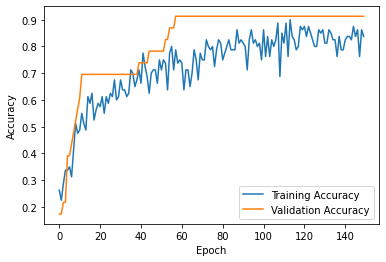

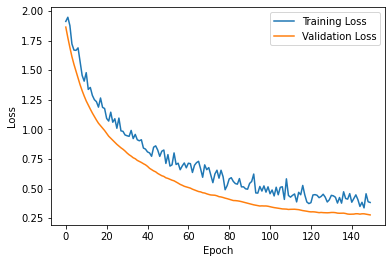

Best validation accuracy: 0.9130434989929199
Training accuracy at the best test accuracy: 0.7875000238418579
Best validation accuracy: 0.9130434989929199
Training accuracy at the best test accuracy: 0.7875000238418579
Confusion matrix:
[[5 0 0 0 0 0]
 [0 2 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 9 0 0]
 [0 0 0 0 3 0]
 [0 0 0 2 0 1]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 81.81818181818183
Accuracy for 4 : 100.0
Accuracy for 5 : 100.0
Total Precision: 0.9696969696969697
Total Recall: 0.8888888888888888
Total F1 Score: 0.9
Accuracy for each label: [100.         100.         100.          81.81818182 100.
 100.        ]
Precision for each label: [1.         1.         1.         0.81818182 1.         1.        ]
Recall for each label: [1.         1.         1.         1.         1.         0.33333333]
F1 Score for each label: [1.  1.  1.  0.9 1.  0.5]
Total Accuracy: 91.30434782608695


In [17]:
run_model(ratio_4, callback_4)

/tmp/ipykernel_34538/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_34538/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_34538/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data = train_data.append(cls_train)
/tmp/ipykernel_34538/2024896522.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_data = test_data.append(cls_test)
/tmp/ipykernel_34538/2024896522.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versio

Epoch 1/150
23/23 [==============================] - 1s 15ms/step - loss: 1.8430 - accuracy: 0.1910 - val_loss: 1.6439 - val_accuracy: 0.2143
Epoch 2/150
23/23 [==============================] - 0s 4ms/step - loss: 1.6903 - accuracy: 0.3708 - val_loss: 1.5571 - val_accuracy: 0.2143
Epoch 3/150
23/23 [==============================] - 0s 6ms/step - loss: 1.6376 - accuracy: 0.3933 - val_loss: 1.4817 - val_accuracy: 0.5000
Epoch 4/150
23/23 [==============================] - 0s 6ms/step - loss: 1.5720 - accuracy: 0.4944 - val_loss: 1.4132 - val_accuracy: 0.6429
Epoch 5/150
23/23 [==============================] - 0s 4ms/step - loss: 1.5360 - accuracy: 0.4382 - val_loss: 1.3519 - val_accuracy: 0.6429
Epoch 6/150
23/23 [==============================] - 0s 6ms/step - loss: 1.4210 - accuracy: 0.5393 - val_loss: 1.2956 - val_accuracy: 0.7143
Epoch 7/150
23/23 [==============================] - 0s 5ms/step - loss: 1.3502 - accuracy: 0.5955 - val_loss: 1.2434 - val_accuracy: 0.7143
Epoch 8/150


Epoch 59/150
23/23 [==============================] - 0s 4ms/step - loss: 0.5877 - accuracy: 0.8090 - val_loss: 0.4519 - val_accuracy: 0.9286
Epoch 60/150
23/23 [==============================] - 0s 4ms/step - loss: 0.5591 - accuracy: 0.8090 - val_loss: 0.4470 - val_accuracy: 0.9286
Epoch 61/150
23/23 [==============================] - 0s 4ms/step - loss: 0.6506 - accuracy: 0.7528 - val_loss: 0.4376 - val_accuracy: 0.9286
Epoch 62/150
23/23 [==============================] - 0s 4ms/step - loss: 0.5774 - accuracy: 0.7978 - val_loss: 0.4287 - val_accuracy: 0.9286
Epoch 63/150
23/23 [==============================] - 0s 4ms/step - loss: 0.5107 - accuracy: 0.8202 - val_loss: 0.4222 - val_accuracy: 0.9286
Epoch 64/150
23/23 [==============================] - 0s 4ms/step - loss: 0.5395 - accuracy: 0.7865 - val_loss: 0.4195 - val_accuracy: 0.9286
Epoch 65/150
23/23 [==============================] - 0s 5ms/step - loss: 0.5060 - accuracy: 0.8539 - val_loss: 0.4216 - val_accuracy: 0.9286
Epoch 

23/23 [==============================] - 0s 3ms/step - loss: 0.3654 - accuracy: 0.8202 - val_loss: 0.3102 - val_accuracy: 0.9286
Epoch 117/150
23/23 [==============================] - 0s 4ms/step - loss: 0.3670 - accuracy: 0.8539 - val_loss: 0.3093 - val_accuracy: 0.9286
Epoch 118/150
23/23 [==============================] - 0s 3ms/step - loss: 0.3797 - accuracy: 0.8652 - val_loss: 0.3136 - val_accuracy: 0.9286
Epoch 119/150
23/23 [==============================] - 0s 4ms/step - loss: 0.3685 - accuracy: 0.8427 - val_loss: 0.3115 - val_accuracy: 0.9286
Epoch 120/150
23/23 [==============================] - 0s 4ms/step - loss: 0.3788 - accuracy: 0.8315 - val_loss: 0.3154 - val_accuracy: 0.9286
Epoch 121/150
23/23 [==============================] - 0s 3ms/step - loss: 0.3348 - accuracy: 0.8652 - val_loss: 0.3125 - val_accuracy: 0.9286
Epoch 122/150
23/23 [==============================] - 0s 3ms/step - loss: 0.3937 - accuracy: 0.8315 - val_loss: 0.3156 - val_accuracy: 0.9286
Epoch 123/150

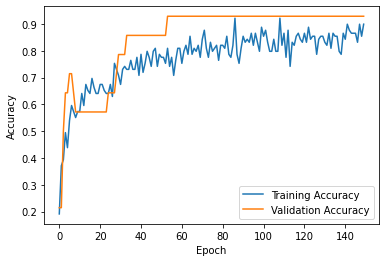

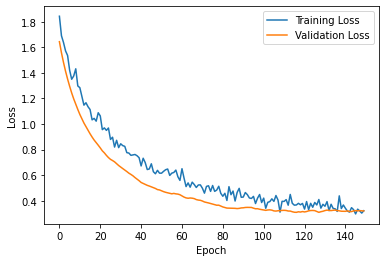

Best validation accuracy: 0.9285714030265808
Training accuracy at the best test accuracy: 0.8089887499809265
Best validation accuracy: 0.9285714030265808
Training accuracy at the best test accuracy: 0.8089887499809265
Confusion matrix:
[[3 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 5 0 0]
 [0 0 0 0 2 0]
 [0 0 0 1 0 1]]
Accuracy for 0 : 100.0
Accuracy for 1 : 100.0
Accuracy for 2 : 100.0
Accuracy for 3 : 83.33333333333334
Accuracy for 4 : 100.0
Accuracy for 5 : 100.0
Total Precision: 0.9722222222222223
Total Recall: 0.9166666666666666
Total F1 Score: 0.9292929292929294
Accuracy for each label: [100.         100.         100.          83.33333333 100.
 100.        ]
Precision for each label: [1.         1.         1.         0.83333333 1.         1.        ]
Recall for each label: [1.  1.  1.  1.  1.  0.5]
F1 Score for each label: [1.         1.         1.         0.90909091 1.         0.66666667]
Total Accuracy: 92.85714285714286


In [18]:
run_model(ratio_5, callback_5)

# 

# N